In [212]:
import warnings
warnings.filterwarnings('ignore')   

In [122]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns
%matplotlib inline


In [123]:
sns.set()

In [124]:
df = pd.read_csv("automation-protocol-ii.csv")

In [125]:
df.columns = df.columns.str.lower()
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 22:58:04
1,271,65538,2,1605868423,1,efd275,48,2020-11-20 22:58:04
2,272,65540,2,1605882795,0,efd275,100,2020-11-20 22:58:04
3,273,65545,2,1605831076,0,efd275,50,2020-11-20 22:58:04
4,274,65546,2,1605892658,0,f1e0b5,50,2020-11-20 22:58:04


## Data cleaning

In [126]:
df.protocoltime = pd.to_datetime(df.protocoltime)
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 22:58:04
1,271,65538,2,1605868423,1,efd275,48,2020-11-20 22:58:04
2,272,65540,2,1605882795,0,efd275,100,2020-11-20 22:58:04
3,273,65545,2,1605831076,0,efd275,50,2020-11-20 22:58:04
4,274,65546,2,1605892658,0,f1e0b5,50,2020-11-20 22:58:04


In [127]:
df.protocoltime = df.protocoltime.round('15min')
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:00:00
1,271,65538,2,1605868423,1,efd275,48,2020-11-20 23:00:00
2,272,65540,2,1605882795,0,efd275,100,2020-11-20 23:00:00
3,273,65545,2,1605831076,0,efd275,50,2020-11-20 23:00:00
4,274,65546,2,1605892658,0,f1e0b5,50,2020-11-20 23:00:00


### Data enriching

In [128]:
devices = df.instanceid.unique()
devices

array([65537, 65538, 65540, 65545, 65546, 65547, 65548, 65549, 65551,
       65552, 65553, 65554, 65555, 65556, 65557])

In [129]:
absolute_min_date = df.protocoltime.min(axis=0)
absolute_max_date = df.protocoltime.max(axis=0)
print("absolute_min_date=%s, absolute_max_date=%s" % (absolute_min_date, absolute_max_date))

complete_time_data = pd.date_range(absolute_min_date, absolute_max_date, freq="15min")
complete_time_data = complete_time_data.tz_localize(None)

complete_arr = []

for device in devices:
    single_device = df[df["instanceid"] == device]
    single_device["protocoltime"] = pd.to_datetime(single_device["protocoltime"]).apply(lambda x: x.replace(tzinfo=None))
    last_state = single_device.iloc[0]
    last_state["onoff"] = 0
    for time_data in complete_time_data.values:
        if time_data in single_device.protocoltime.values:
            # TODO edge case for multiple events in one time slot
            device_row = single_device[single_device["protocoltime"] == time_data]
            complete_arr.append(device_row.values[0])
            last_state = device_row.iloc[0]
        else:
            current_state = last_state.copy()
            current_state["protocoltime"] = time_data
            complete_arr.append(current_state.values)

df = pd.DataFrame(complete_arr, columns=df.columns)
df = df.sort_values(by=["instanceid", "protocoltime"])
df.head()

absolute_min_date=2020-11-20 23:00:00, absolute_max_date=2020-11-28 18:15:00


,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:00:00
1,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:15:00
2,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:30:00
3,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:45:00
4,304,65537,2,1605867202,0,f1e0b5,51,2020-11-21 00:00:00


In [130]:
len(df)

11250

In [131]:
df.color[df.color == 0] = "f1e0b5" 

In [132]:
df["weekday"] = df.protocoltime.dt.day_name()
df["weekofyear"] = df.protocoltime.dt.weekofyear
df["year"] = df.protocoltime.dt.year
df["month"] = df.protocoltime.dt.month
df["day"] = df.protocoltime.dt.day
df["time"] = df.protocoltime.dt.strftime("%H:%M")
df.head()

,id,instanceid,type,lastseen,onoff,color,dimmer,protocoltime,weekday,weekofyear,year,month,day,time
0,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:00:00,Friday,47,2020,11,20,23:00
1,270,65537,2,1605867202,1,efd275,51,2020-11-20 23:15:00,Friday,47,2020,11,20,23:15
2,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:30:00,Friday,47,2020,11,20,23:30
3,285,65537,2,1605867202,1,efd275,51,2020-11-20 23:45:00,Friday,47,2020,11,20,23:45
4,304,65537,2,1605867202,0,f1e0b5,51,2020-11-21 00:00:00,Saturday,47,2020,11,21,00:00


In [133]:
df.columns

Index(['id', 'instanceid', 'type', 'lastseen', 'onoff', 'color', 'dimmer',
       'protocoltime', 'weekday', 'weekofyear', 'year', 'month', 'day',
       'time'],
      dtype='object')

In [134]:
df.color.unique()

array(['efd275', 'f1e0b5', 'f5faf6', '0', 'f2eccf', 'ffe2c4'],
      dtype=object)

In [135]:
df.color.value_counts()

f1e0b5    8326
efd275    1338
f5faf6    1094
0          206
ffe2c4     192
f2eccf      94
Name: color, dtype: int64

In [136]:
if "id" in df.columns:
    del df["id"]
if "lastseen" in df.columns:
    del df["lastseen"]
if "protocoltime" in df.columns:
    del df["protocoltime"]
df.head()

,instanceid,type,onoff,color,dimmer,weekday,weekofyear,year,month,day,time
0,65537,2,1,efd275,51,Friday,47,2020,11,20,23:00
1,65537,2,1,efd275,51,Friday,47,2020,11,20,23:15
2,65537,2,1,efd275,51,Friday,47,2020,11,20,23:30
3,65537,2,1,efd275,51,Friday,47,2020,11,20,23:45
4,65537,2,0,f1e0b5,51,Saturday,47,2020,11,21,00:00


## Data exploration

In [137]:
df.to_csv("parsed-data.csv", index=False)

In [138]:
df.describe()

,instanceid,type,onoff,dimmer,weekofyear,year,month,day
count,11250.000000,11250.0,11250.000000,11250.000000,11250.000000,11250.0,11250.0,11250.000000
mean,65548.533333,2.0,0.349956,80.741422,47.738667,2020.0,11.0,24.373333
std,6.195614,0.0,0.476977,26.302173,0.439381,0.0,0.0,2.260327
min,65537.000000,2.0,0.000000,8.000000,47.000000,2020.0,11.0,20.000000
25%,65545.000000,2.0,0.000000,50.000000,47.000000,2020.0,11.0,22.000000
50%,65549.000000,2.0,0.000000,100.000000,48.000000,2020.0,11.0,24.000000
75%,65554.000000,2.0,1.000000,100.000000,48.000000,2020.0,11.0,26.000000
max,65557.000000,2.0,1.000000,100.000000,48.000000,2020.0,11.0,28.000000


In [139]:
df.isnull().sum()

instanceid    0
type          0
onoff         0
color         0
dimmer        0
weekday       0
weekofyear    0
year          0
month         0
day           0
time          0
dtype: int64

In [140]:
df.time.unique()

array(['23:00', '23:15', '23:30', '23:45', '00:00', '00:15', '00:30',
       '00:45', '01:00', '01:15', '01:30', '01:45', '02:00', '02:15',
       '02:30', '02:45', '03:00', '03:15', '03:30', '03:45', '04:00',
       '04:15', '04:30', '04:45', '05:00', '05:15', '05:30', '05:45',
       '06:00', '06:15', '06:30', '06:45', '07:00', '07:15', '07:30',
       '07:45', '08:00', '08:15', '08:30', '08:45', '09:00', '09:15',
       '09:30', '09:45', '10:00', '10:15', '10:30', '10:45', '11:00',
       '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45',
       '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30',
       '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15',
       '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00',
       '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45',
       '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30',
       '21:45', '22:00', '22:15', '22:30', '22:45'], dtype=object)

In [141]:
pd.Timestamp("16:15").round("1h").strftime("%H:%M")

'16:00'

### Distribution of on/off states

on=3937, off=7313


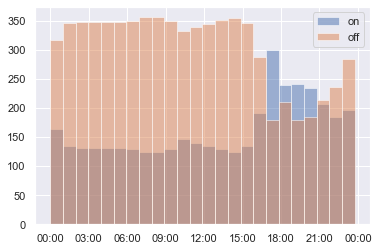

In [142]:
time_df = df.copy()
time_df.time = time_df.time.map(lambda x: pd.Timestamp(x).round('15min'))
time_df_on = time_df[time_df.onoff == 1].time
time_df_off = time_df[time_df.onoff == 0].time

print("on=%d, off=%d" % (len(time_df_on), len(time_df_off)))

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.hist(time_df_on, bins=24, label="on", alpha=0.5)
plt.hist(time_df_off, bins=24, label="off", alpha=0.5)
# ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 23, 1)))
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.legend()
plt.show()

### Distribution of on/off states over time with KDE

In [143]:
time_df_cnt = time_df.copy()
time_df_cnt.time = time_df_cnt.time.map(lambda x: x.strftime("%H:%M"))

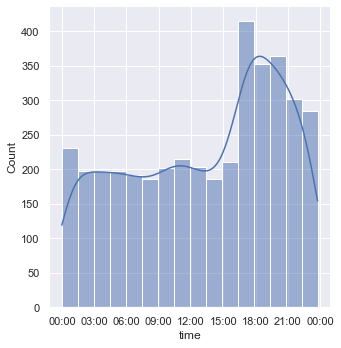

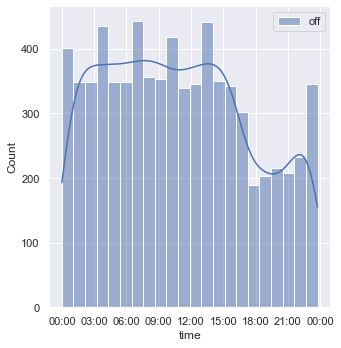

In [144]:
sns.displot(data=time_df_on, label="on", kde=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

sns.displot(data=time_df_off, label="off", kde=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.legend()
plt.show()

### On/Off state for specific lamp over time

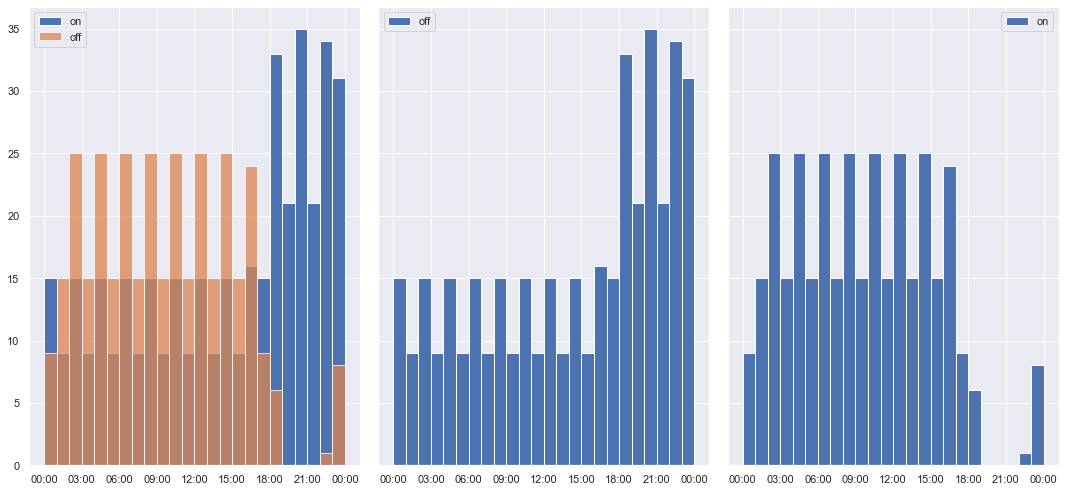

In [145]:
lamp_df = df.copy()
lamp_df = lamp_df[lamp_df.instanceid == 65538]
lamp_df.time = lamp_df.time.map(lambda x: pd.Timestamp(x).round('1h'))
lamp_df_on = lamp_df[lamp_df.onoff == 1].time
lamp_df_off = lamp_df[lamp_df.onoff == 0].time

figure, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 7), sharey=True)
ax01 = axes[0]
ax01.hist(lamp_df_on, bins=24, label="on", alpha=1)
ax01.hist(lamp_df_off, bins=24, label="off", alpha=0.75)
ax01.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax01.legend()

ax02 = axes[1]
ax02.hist(lamp_df_on, bins=24, label="off")
ax02.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax02.legend()

ax03 = axes[2]
ax03.hist(lamp_df_off, bins=24, label="on")
ax03.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax03.legend()

figure.tight_layout()
plt.show()

### Distribution on on/off states over week days

on=3937, off=7313


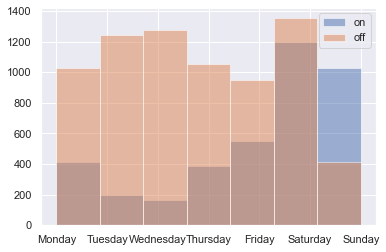

In [146]:
time_df = df.copy()
weekday_category = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_type = CategoricalDtype(categories=weekday_category, ordered=True)
time_df["weekday"] = time_df["weekday"].astype(weekday_type)
time_df = time_df.sort_values("weekday")
time_df_on = time_df[time_df.onoff == 1].weekday
time_df_off = time_df[time_df.onoff == 0].weekday

print("on=%d, off=%d" % (len(time_df_on), len(time_df_off)))

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.hist(time_df_on, bins=7, label="on", alpha=0.5)
plt.hist(time_df_off, bins=7, label="off", alpha=0.5)
# ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 23, 1)))
# ax = plt.gca()
# ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

plt.legend()
plt.show()

## Data preparation

In [147]:
# del df["weekday"]
del df["weekofyear"] 
del df["year"] 
del df["month"] 
del df["day"]
del df["color"]
del df["dimmer"]
df.head()

,instanceid,type,onoff,weekday,time
0,65537,2,1,Friday,23:00
1,65537,2,1,Friday,23:15
2,65537,2,1,Friday,23:30
3,65537,2,1,Friday,23:45
4,65537,2,0,Saturday,00:00


In [148]:
from sklearn.model_selection import train_test_split

In [149]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [150]:
y_train_full_onoff = (df_train_full.onoff == 1).values
y_train_onoff = (df_train.onoff == 1).values
y_val_onoff = (df_val.onoff == 1).values
y_test_onoff = (df_test.onoff == 1).values

In [151]:
del df_train_full["onoff"]
del df_train["onoff"]
del df_val["onoff"]
del df_test["onoff"]

### One-Hot encoding

In [152]:
from sklearn.feature_extraction import DictVectorizer

In [153]:
dv = DictVectorizer(sparse=False)
dv_full = DictVectorizer(sparse=False)

In [154]:
dict_train_full_onoff = df_train_full.to_dict(orient="records")
dict_train_onoff = df_train.to_dict(orient="records")
dict_val_onoff = df_val.to_dict(orient="records")
dict_test_onoff = df_test.to_dict(orient="records")

In [155]:
X_train_full_onoff = dv_full.fit_transform(dict_train_full_onoff)
X_train_onoff = dv.fit_transform(dict_train_onoff)
X_val_onoff = dv.transform(dict_val_onoff)
X_test_onoff = dv_full.transform(dict_test_onoff)

## Training

### Logistic Regression

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

#### Optimization

In [157]:
for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    lr = LogisticRegression(solver='liblinear', C=C, random_state=1)
    lr.fit(X_train_onoff, y_train_onoff)
    
    y_pred = lr.predict_proba(X_val_onoff)[:, 1]
    auc = roc_auc_score(y_val_onoff, y_pred)
    print('C=%.3f => auc = %0.3f' % (C, auc))


C=0.001 => auc = 0.614
C=0.010 => auc = 0.614
C=0.100 => auc = 0.614
C=0.500 => auc = 0.614
C=1.000 => auc = 0.614
C=10.000 => auc = 0.614


#### Final model

In [158]:
lr = LogisticRegression(solver='liblinear', C=0.1, random_state=1)
lr.fit(X_train_full_onoff, y_train_full_onoff)

LogisticRegression(C=0.1, random_state=1, solver='liblinear')

### Decision trees

In [159]:
from sklearn.tree import DecisionTreeClassifier

#### Final model

In [160]:
dt = DecisionTreeClassifier()
dt.fit(X_train_full_onoff, y_train_full_onoff)

DecisionTreeClassifier()

### Random forest

In [161]:
from sklearn.ensemble import RandomForestClassifier

#### Parameter optimization

In [162]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train_onoff, y_train_onoff)

RandomForestClassifier(n_estimators=10, random_state=3)

In [163]:
y_pred = rf.predict_proba(X_val_onoff)[:, 1]
roc_auc_score(y_val_onoff, y_pred)

0.8867343964334704

**n_estimators**

In [164]:
aucs = []
for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train_onoff, y_train_onoff)

    y_pred = rf.predict_proba(X_val_onoff)[:, 1]
    auc = roc_auc_score(y_val_onoff, y_pred)
    print("%s -> %.3f" % (i, auc))
    aucs.append(auc)

10 -> 0.887
20 -> 0.902
30 -> 0.904
40 -> 0.905
50 -> 0.905
60 -> 0.906
70 -> 0.905
80 -> 0.905
90 -> 0.905
100 -> 0.905
110 -> 0.905
120 -> 0.905
130 -> 0.905
140 -> 0.905
150 -> 0.906
160 -> 0.905
170 -> 0.905
180 -> 0.905
190 -> 0.905
200 -> 0.905


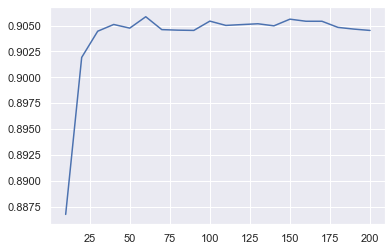

In [165]:
plt.plot(range(10, 201, 10), aucs)

**max_depth**

In [166]:
depths = [5, 10, 20, 50, None]
all_aucs = {}
for depth in depths:
    print("depth: %s" % depth)
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=3)
        rf.fit(X_train_onoff, y_train_onoff)

        y_pred = rf.predict_proba(X_val_onoff)[:, 1]
        auc = roc_auc_score(y_val_onoff, y_pred)
        print("%s -> %.3f" % (i, auc))

        aucs.append(auc)
    
    all_aucs[depth] = aucs
    print()

depth: 5
10 -> 0.759
20 -> 0.788
30 -> 0.792
40 -> 0.786
50 -> 0.791
60 -> 0.796
70 -> 0.795
80 -> 0.796
90 -> 0.797
100 -> 0.796
110 -> 0.796
120 -> 0.796
130 -> 0.796
140 -> 0.795
150 -> 0.795
160 -> 0.795
170 -> 0.795
180 -> 0.796
190 -> 0.796
200 -> 0.796

depth: 10
10 -> 0.790
20 -> 0.815
30 -> 0.818
40 -> 0.818
50 -> 0.816
60 -> 0.819
70 -> 0.819
80 -> 0.819
90 -> 0.818
100 -> 0.821
110 -> 0.820
120 -> 0.821
130 -> 0.822
140 -> 0.823
150 -> 0.823
160 -> 0.823
170 -> 0.824
180 -> 0.824
190 -> 0.824
200 -> 0.824

depth: 20
10 -> 0.853
20 -> 0.872
30 -> 0.875
40 -> 0.872
50 -> 0.872
60 -> 0.875
70 -> 0.875
80 -> 0.873
90 -> 0.873
100 -> 0.874
110 -> 0.873
120 -> 0.875
130 -> 0.877
140 -> 0.878
150 -> 0.877
160 -> 0.875
170 -> 0.876
180 -> 0.876
190 -> 0.876
200 -> 0.877

depth: 50
10 -> 0.892
20 -> 0.910
30 -> 0.913
40 -> 0.914
50 -> 0.912
60 -> 0.911
70 -> 0.910
80 -> 0.910
90 -> 0.911
100 -> 0.912
110 -> 0.911
120 -> 0.912
130 -> 0.912
140 -> 0.911
150 -> 0.911
160 -> 0.911
170 ->

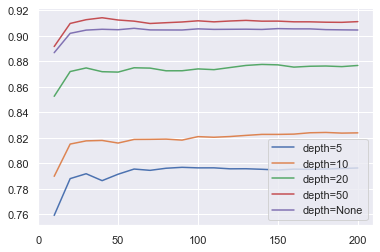

In [167]:
num_trees = list(range(10, 201, 10))
for depth in depths:
    plt.plot(num_trees, all_aucs[depth], label=("depth=%s" % depth))
plt.xticks(range(0, 201, 50))
plt.legend()

**min_samples_leaf**

In [168]:
msls = [3, 5, 10]
all_aucs = {}
for m in msls:
    print("min_samples_leaf: %s" % m)
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=50, min_samples_leaf=m, random_state=1)
        rf.fit(X_train_onoff, y_train_onoff)

        y_pred = rf.predict_proba(X_val_onoff)[:, 1]
        auc = roc_auc_score(y_val_onoff, y_pred)
        print("%s -> %.3f" % (i, auc))

        aucs.append(auc)
    
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.893
20 -> 0.903
30 -> 0.902
40 -> 0.903
50 -> 0.902
60 -> 0.901
70 -> 0.902
80 -> 0.903
90 -> 0.902
100 -> 0.902
110 -> 0.902
120 -> 0.902
130 -> 0.903
140 -> 0.903
150 -> 0.903
160 -> 0.903
170 -> 0.903
180 -> 0.902
190 -> 0.902
200 -> 0.902

min_samples_leaf: 5
10 -> 0.869
20 -> 0.879
30 -> 0.879
40 -> 0.878
50 -> 0.877
60 -> 0.877
70 -> 0.876
80 -> 0.876
90 -> 0.877
100 -> 0.878
110 -> 0.877
120 -> 0.877
130 -> 0.878
140 -> 0.878
150 -> 0.878
160 -> 0.879
170 -> 0.879
180 -> 0.879
190 -> 0.879
200 -> 0.879

min_samples_leaf: 10
10 -> 0.817
20 -> 0.833
30 -> 0.824
40 -> 0.821
50 -> 0.820
60 -> 0.820
70 -> 0.822
80 -> 0.823
90 -> 0.827
100 -> 0.827
110 -> 0.827
120 -> 0.825
130 -> 0.825
140 -> 0.825
150 -> 0.826
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825



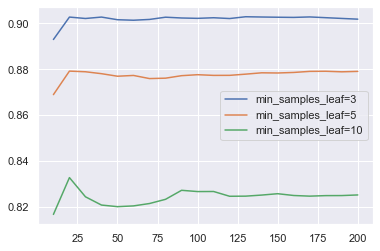

In [169]:
num_trees = list(range(10, 201, 10))
for m in msls:
    plt.plot(num_trees, all_aucs[m], label=("min_samples_leaf=%s" % m))
plt.legend()

Best parameters are: n_estimators=25, max_depth=50, min_samples_leaf=3

#### Final model

In [170]:
rf = RandomForestClassifier(n_estimators=25, max_depth=50, min_samples_leaf=3, random_state=3)
rf.fit(X_train_full_onoff, y_train_full_onoff)

RandomForestClassifier(max_depth=50, min_samples_leaf=3, n_estimators=25,
                       random_state=3)

### Gradient boost

In [171]:
import xgboost as xgb

In [204]:
dtrain_full_onoff = xgb.DMatrix(X_train_full_onoff, label=y_train_full_onoff, feature_names=dv_full.feature_names_)
dtrain_onoff = xgb.DMatrix(X_train_onoff, label=y_train_onoff, feature_names=dv.feature_names_)
dval_onoff = xgb.DMatrix(X_val_onoff, label=y_val_onoff, feature_names=dv.feature_names_)
dtest_onoff = xgb.DMatrix(X_test_onoff, label=y_test_onoff, feature_names=dv_full.feature_names_)

In [173]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
}

In [174]:
watchlist = [(dtrain_onoff, 'train'), (dval, 'val')]

In [175]:
model = xgb.train(xgb_params, dtrain_onoff, num_boost_round=70, evals=watchlist, verbose_eval=10)

[0]	train-error:0.25807	val-error:0.27600
[10]	train-error:0.23259	val-error:0.24533
[20]	train-error:0.23556	val-error:0.23244
[30]	train-error:0.23096	val-error:0.22844
[40]	train-error:0.22667	val-error:0.22400
[50]	train-error:0.22178	val-error:0.22089
[60]	train-error:0.21896	val-error:0.21556
[69]	train-error:0.21570	val-error:0.21200


In [176]:
y_pred = model.predict(dval_onoff)
roc_auc_score(y_val_onoff, y_pred)

0.8729998285322359

In [177]:
def parse_xgb_output(output):
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)

    return tree, aucs_train, aucs_val

#### Parameter optimization

**eta & num_boost_round**

In [178]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain_onoff,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [179]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.94038
(0.94038, 490)


In [180]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain_onoff,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [181]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.93258
(0.93258, 499)


In [182]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain_onoff,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [183]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.93017
(0.93017, 499)


In [184]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain_onoff,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [185]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.91485
(0.91485, 499)


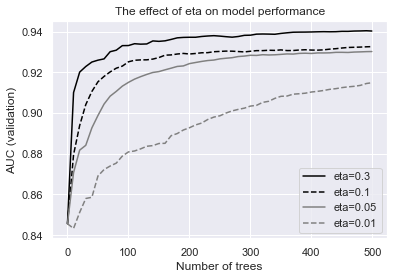

In [197]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, color='grey', linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, color='grey', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

plt.show()

Best parameters so far: eta=0.3, num_boost_round=490

**colsample_bytree**

colsample_bytree=0.1 -> 0.897
colsample_bytree=0.2 -> 0.932
colsample_bytree=0.3 -> 0.935
colsample_bytree=0.4 -> 0.936
colsample_bytree=0.5 -> 0.941
colsample_bytree=0.6 -> 0.940
colsample_bytree=0.7 -> 0.939
colsample_bytree=0.8 -> 0.940
colsample_bytree=0.9 -> 0.940


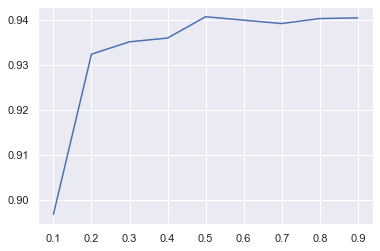

In [201]:
aucs = []
for n in np.arange(0.1, 1, 0.1):
    xgb_params_loop = {
        'eta': 0.3,
        'max_depth': 6,
        'min_child_weight': 1,
        'colsample_bytree': n,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
    }
    model_loop = xgb.train(xgb_params_loop, dtrain_onoff, num_boost_round=490)
    y_pred_loop = model_loop.predict(dval_onoff)

    auc = roc_auc_score(y_val_onoff, y_pred_loop)
    print("colsample_bytree=%.1f -> %.3f" % (n, auc))
    aucs.append(auc)

plt.plot(np.arange(0.1, 1, 0.1), aucs)

Best parameters so far: eta=0.3, num_boost_round=490, colsample_bytree=0.5

**subsampling**

[22:40:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { subsampling } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


subsampling=0.4 -> 0.905
[22:41:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { subsampling } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


subsampling=0.5 -> 0.905
[22:41:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { subsampling } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to 

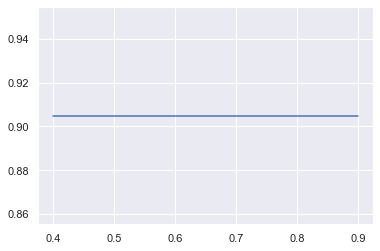

In [202]:
aucs = []
for subsampling in np.arange(0.4, 1, 0.1):
    xgb_params_loop = {
        'eta': 0.01,
        'max_depth': 6,
        'min_child_weight': 1,
        'colsample_bytree': 0.5,
        'subsampling': subsampling,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'nthread': 8,
        'seed': 1,
    }
    model_loop = xgb.train(xgb_params_loop, dtrain_onoff, num_boost_round=490)
    y_pred_loop = model_loop.predict(dval_onoff)
    
    auc = roc_auc_score(y_val_onoff, y_pred_loop)
    print("subsampling=%.1f -> %.3f" % (subsampling, auc))
    aucs.append(auc)

plt.plot(np.arange(0.4, 1, 0.1), aucs)

Best parameter choice: eta=0.3, num_boost_round=490, colsample_bytree=0.5, subsampling=0.5

#### Final model

In [205]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 0.5,
    'subsampling': 0.5,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain_full_onoff, num_boost_round=490)

[22:46:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { subsampling } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




## Evaluation

### Logistic regression

In [188]:
y_pred_lr = lr.predict_proba(X_test_onoff)[:, 1]
accuracy = (y_test_onoff == (y_pred_lr >= 0.5)).mean()

auc = roc_auc_score(y_test_onoff, y_pred_lr)

print("LR accuracy:", accuracy)
print("LR auc:", auc)

LR accuracy: 0.6475555555555556
LR auc: 0.5929668573940995


### Decision trees

In [189]:
y_pred_dt = dt.predict_proba(X_test_onoff)[:, 1]
accuracy = (y_test_onoff == (y_pred_dt >= 0.5)).mean()

auc = roc_auc_score(y_test_onoff, y_pred_dt) 

print("LR accuracy:", accuracy)
print("LR auc:", auc)

LR accuracy: 0.8417777777777777
LR auc: 0.8308907470220295


### Random forest

In [190]:
rf = RandomForestClassifier(n_estimators=25, max_depth=50, min_samples_leaf=3, random_state=3)
rf.fit(X_train_onoff, y_train_onoff)
y_pred_rf = rf.predict_proba(X_val_onoff)[:, 1]
accuracy = (y_val_onoff == (y_pred_rf >= 0.5)).mean()

auc = roc_auc_score(y_val_onoff, y_pred_rf)

print("LR accuracy (X_val):", accuracy)
print("LR auc (X_val):", auc)

print()

rf = RandomForestClassifier(n_estimators=25, max_depth=50, min_samples_leaf=3, random_state=3)
rf.fit(X_train_full_onoff, y_train_full_onoff)
y_pred_rf = rf.predict_proba(X_test_onoff)[:, 1]
accuracy = (y_test_onoff == (y_pred >= 0.5)).mean()

auc = roc_auc_score(y_test_onoff, y_pred_rf)
 
print("LR accuracy (X_test):", accuracy)
print("LR auc (X_test):", auc)

LR accuracy (X_val): 0.8026666666666666
LR auc (X_val): 0.906346450617284

LR accuracy (X_test): 0.5884444444444444
LR auc (X_test): 0.9073425589903419


### Gradient boost

In [209]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,
    'colsample_bytree': 0.5,
    'subsampling': 0.5,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1
}

gb_model = xgb.train(xgb_params, dtrain_onoff, num_boost_round=490)
y_pred_gb = gb_model.predict(dval_onoff)

accuracy = (y_val_onoff == (y_pred_gb >= 0.5)).mean()
auc = roc_auc_score(y_val_onoff, y_pred_gb)

print("GB accuracy (X_val):", accuracy)
print("GB auc (X_val):", auc)

gb_model = xgb.train(xgb_params, dtrain_full_onoff, num_boost_round=490)
y_pred_gb = gb_model.predict(dtest_onoff)

accuracy = (y_test_onoff == (y_pred_gb >= 0.5)).mean()
auc = roc_auc_score(y_test_onoff, y_pred_gb)

print("GB accuracy (X_test):", accuracy)
print("GB auc (X_test):", auc)

[22:50:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { subsampling } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GB accuracy (X_val): 0.852
GB auc (X_val): 0.932977109053498
[22:50:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { subsampling } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


GB accuracy (X_test): 0.8444444444444444
GB auc (X_test): 0.931452370216055


In [210]:
fpr_lr, tpr_lr, treshold = roc_curve(y_test_onoff, y_pred_lr)
fpr_dt, tpr_dt, treshold = roc_curve(y_test_onoff, y_pred_dt)
fpr_rf, tpr_rf, treshold = roc_curve(y_test_onoff, y_pred_rf)
fpr_gb, tpr_gb, treshold = roc_curve(y_test_onoff, y_pred_gb)

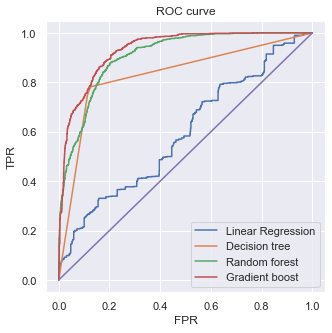

In [211]:
plt.figure(figsize=(5, 5))
plt.plot(fpr_lr, tpr_lr, label='Linear Regression')
plt.plot(fpr_dt, tpr_dt, label='Decision tree')
plt.plot(fpr_rf, tpr_rf, label='Random forest')
plt.plot(fpr_gb, tpr_gb, label='Gradient boost')
plt.plot([0, 1], [0, 1])

plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## Testing the model(s)

In [231]:
example = {
    "instanceid": 65537,
    "type": 2,
    "weekday": "Tuesday",
    "time": "00:30"
}

In [232]:
X_example = dv_full.transform([example])
# pd.DataFrame(X_example, columns=dv.get_feature_names())

In [233]:
rf.predict_proba(X_example)[0, 1]

0.3324398672955955

In [234]:
rf.predict_proba(X_example)[0, 1] >= 0.5

False

In [235]:
dexample = xgb.DMatrix(X_example, feature_names=dv_full.feature_names_)
gb_model.predict(dexample)[0]

0.42567116

In [236]:
gb_model.predict(dexample)[0] >= 0.5

False